# Linker Design

In [1]:
from genmol import GenMol_Generator
from utils import Utils

from rdkit import Chem
from rdkit.Chem import Draw

import safe as sf
import datamol as dm

## Input Fragments

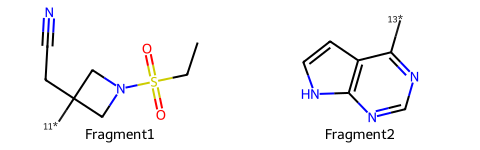

In [2]:
frag1, frag2 = '[11*]C1(CC#N)CN(S(=O)(=O)CC)C1', '[13*]c1ncnc2[nH]ccc12'

Draw.MolsToGridImage([Chem.MolFromSmiles(frag1), Chem.MolFromSmiles(frag2)], 
                      molsPerRow=2, subImgSize=(240, 150), legends=['Fragment1', 'Fragment2'])

In [3]:
smiles_joint = '.'.join([frag1, frag2])

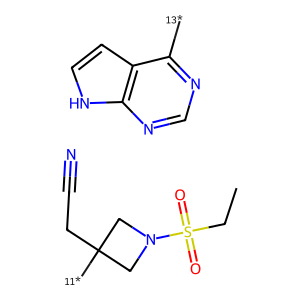

In [4]:
Draw.MolToImage(Chem.MolFromSmiles(smiles_joint))

## Prepare the generator

In [5]:
genmol = GenMol_Generator()

## Method 1: Append a mask at the end

In [6]:
input_text = Utils.smiles2safe(smiles_joint) + '.[*{15-35}]'
input_text

'c14ncnc2[nH]ccc12.C136CN5C1.S5(=O)(=O)CC.C6C#N.[*{15-35}]'

In [7]:
molecules = genmol.inference(smiles = input_text, temperature = 1.5, noise = 1.0, num_molecules=1000)
len(molecules)

42

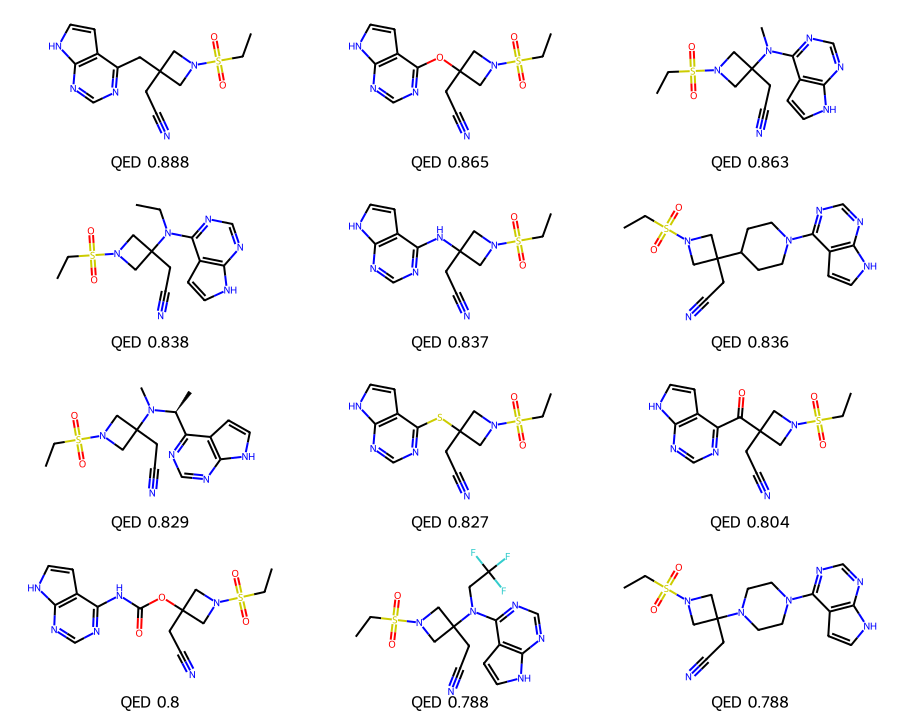

In [8]:
Draw.MolsToGridImage([Chem.MolFromSmiles(_['smiles']) for _ in molecules[:12]], 
                      molsPerRow=3, subImgSize=(300, 180), legends=['QED ' + str(_['score']) for _ in molecules[:12]])

## Method 2: Insert a mask in the middle

In [9]:
input_text = Utils.smiles2safe(smiles_joint).split('.')
input_text

['c14ncnc2[nH]ccc12', 'C136CN5C1', 'S5(=O)(=O)CC', 'C6C#N']

In [10]:
input_text = '.'.join(input_text[:2]) + '.[*{5-15}].' + '.'.join(input_text[2:])
input_text

'c14ncnc2[nH]ccc12.C136CN5C1.[*{5-15}].S5(=O)(=O)CC.C6C#N'

In [11]:
molecules = genmol.inference(smiles = input_text, temperature = 1.5, noise = 1.0, num_molecules=1000)
len(molecules)

18

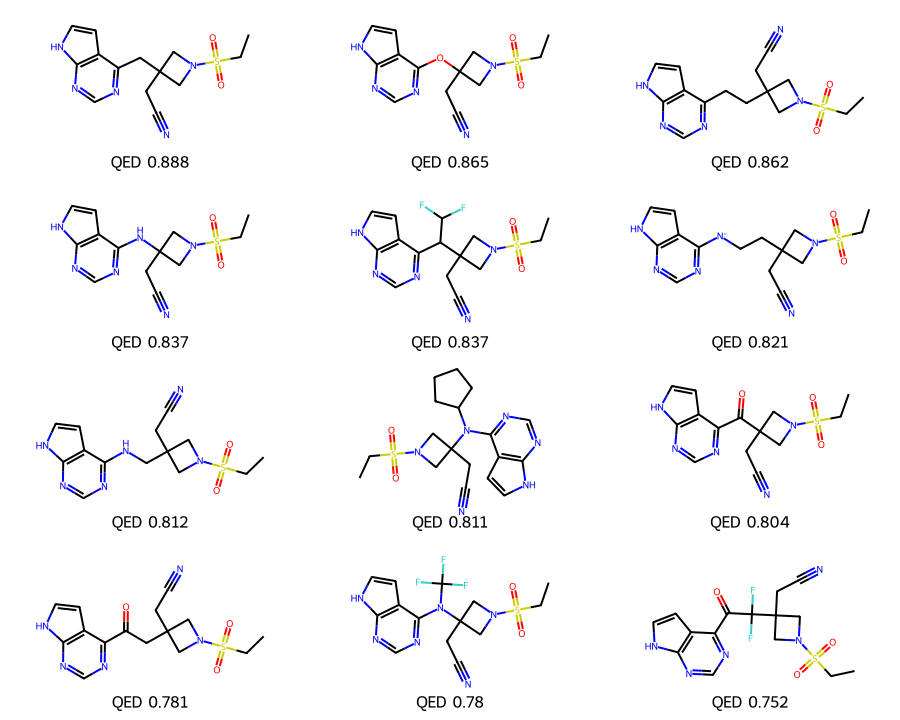

In [12]:
Draw.MolsToGridImage([Chem.MolFromSmiles(_['smiles']) for _ in molecules[:12]], 
                      molsPerRow=3, subImgSize=(300, 180), legends=['QED ' + str(_['score']) for _ in molecules[:12]])

## Method 3: De-Novo + Linking

#### Step 1: Generate random fragments

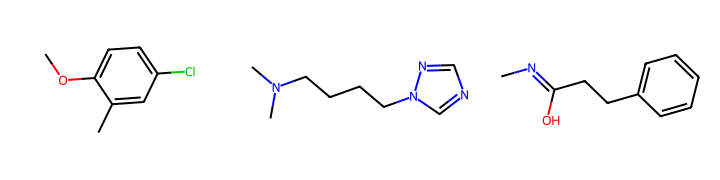

In [13]:
linkers = genmol.inference(smiles = '[*{20-20}]', temperature = 1.5, noise = 1.0, num_molecules=3)
linkers = [_['smiles'] for _ in linkers]
Draw.MolsToGridImage([Chem.MolFromSmiles(_) for _ in linkers], molsPerRow=3, subImgSize=(240, 180))

#### Step 2: Enumerate all fragments with two attachment points

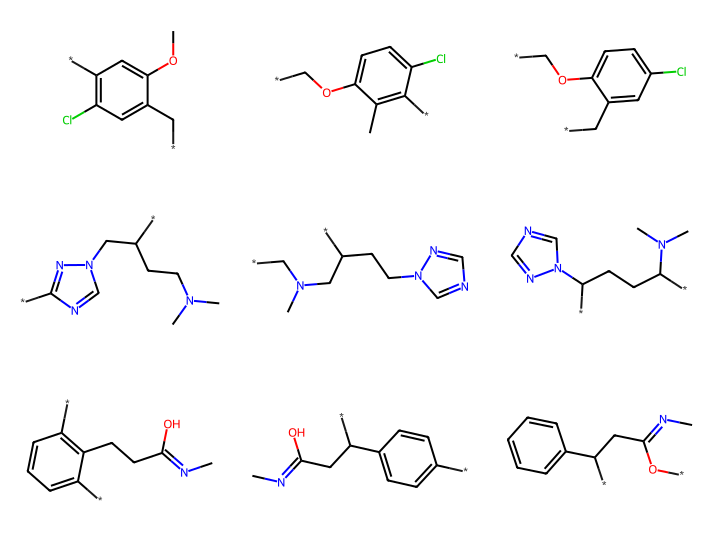

In [14]:
linkers_fragments = []

for linker in linkers:
    linkers_fragments.extend([_ for _ in Utils.attachable_points(linker) if _.count('*') == 2][:3])

Draw.MolsToGridImage([Chem.MolFromSmiles(_) for _ in linkers_fragments], molsPerRow=3, subImgSize=(240, 180))

#### Step 3: Linking

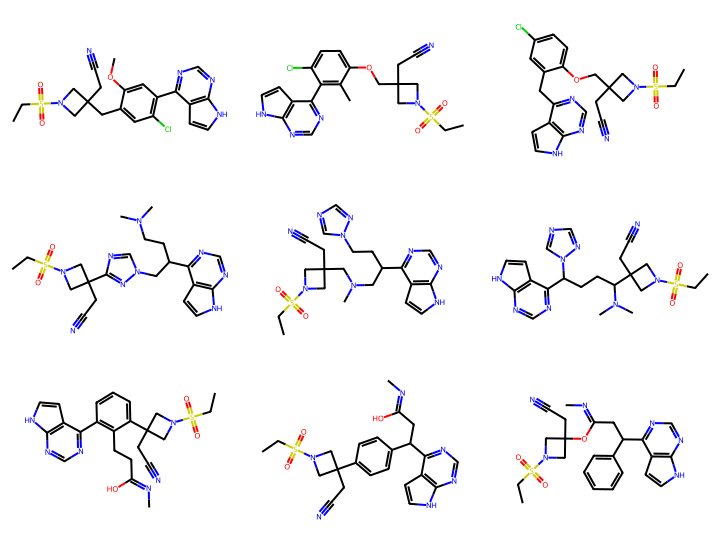

In [15]:
slicer = sf.utils.MolSlicer(require_ring_system=False)
molecules = [slicer.link_fragments(linker, frag1, frag2)[0] for linker in linkers_fragments]
Draw.MolsToGridImage([Chem.MolFromSmiles(_) for _ in molecules], molsPerRow=3, subImgSize=(240, 180))

## Method 4: Motif-Extension + Linking

#### Step 1: Genreate molecules from Fragment-1

**Note:** this example is starting from the fragment 1, but the same method can be started from fragment 2 as well.

In [16]:
extended = genmol.inference(smiles = Utils.smiles2safe(frag1) + '.[*{40-40}]', temperature = 1.5, noise = 1.0, num_molecules=5)
extended = [_['smiles'] for _ in extended]
len(extended)

5

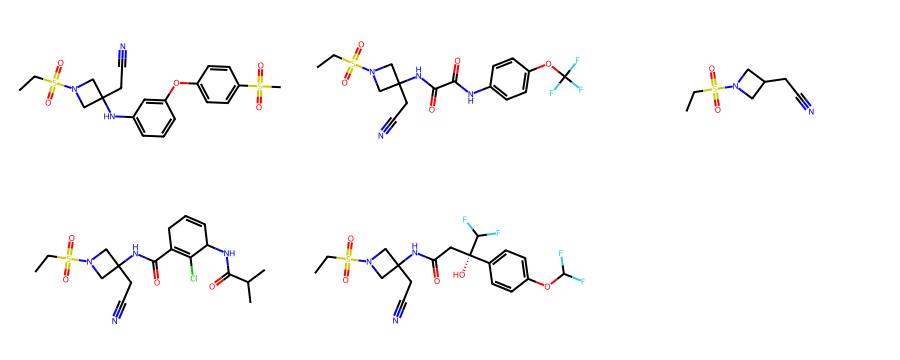

In [17]:
Draw.MolsToGridImage([Chem.MolFromSmiles(_) for _ in extended], molsPerRow=3, subImgSize=(300, 180))

#### Step 2: Cut all generated molecules into three parts: head-linker-tail

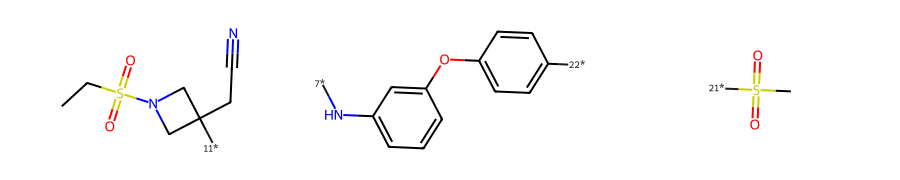

In [18]:
slicer = sf.utils.MolSlicer(require_ring_system=False)
sliced = [slicer(_, expected_head = sf.utils.standardize_attach(frag1, standard_attach='')) for _ in extended]
sliced = [_ for _ in sliced if _[1] is not None]

Draw.MolsToGridImage(sliced[0], molsPerRow=3, subImgSize=(300, 180))

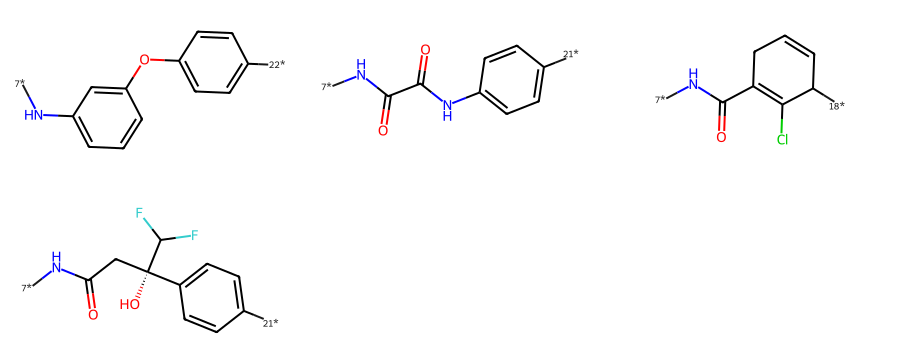

In [19]:
linkers = [_[1] for _ in sliced]
Draw.MolsToGridImage(linkers, molsPerRow=3, subImgSize=(300, 180))

#### Step 3: Linking

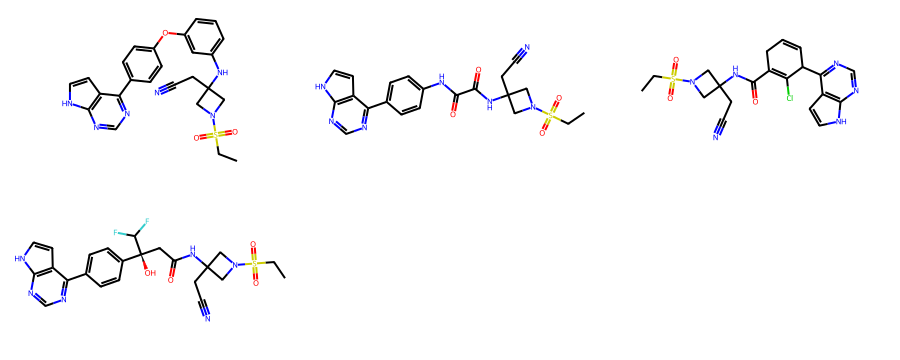

In [20]:
molecules = [slicer.link_fragments(linker, frag1, frag2)[0] for linker in linkers]
Draw.MolsToGridImage([Chem.MolFromSmiles(_) for _ in molecules], molsPerRow=3, subImgSize=(300, 180))